### Import libraries and get data

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pmd

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.arima.model import ARIMA

## Load the dataset

In [17]:
# Load the dataset
df = pd.read_csv("./USDT.csv")

# Drop the unnecessary columns.
df.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1, inplace=True)

# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')
                                    
# Sort the DataFrame by date
df = df.sort_values('Date')

# Set Date index
df.set_index('Date', inplace=True)

df

,Price
Date,
2017-12-01,1.0100
2017-12-02,0.9959
2017-12-03,0.9977
2017-12-04,1.0000
2017-12-05,1.0000
...,...
2023-06-12,1.0000
2023-06-13,0.9999
2023-06-14,0.9998


### Split the data into training, test and validate sets

In [18]:
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1213, 1)
Test shape: (606, 1)
Validate shape: (204, 1)


In [19]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1416, 1)
Test shape: (404, 1)
Validate shape: (203, 1)


In [20]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1213, 1)
Test shape: (404, 1)
Validate shape: (406, 1)


## ARIMA Model

### 3. Perfom ARIMA Model 

In [21]:
!pip install pmdarima

In [22]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

### 3.1 Build the best ARIMA Model using p,d,q from auto_arima

In [23]:
arima_model = pmd.auto_arima(y_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=False,
                         d=None, D=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic


C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-10272.066, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3445.122, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-10300.053, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-10297.819, Time=0.21 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-10300.040, Time=0.34 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-1293.132, Time=0.50 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-10298.051, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-10330.379, Time=0.51 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-9747.749, Time=1.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-10314.470, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-10323.308, Time=0.54 sec
 ARIMA(1,0,3

In [24]:
order = (arima_model.order[0], arima_model.order[1], arima_model.order[2])
print(order)

(1, 0, 2)


In [25]:
def evaluate_ariama_model(x_data, y_data, order):
    y_preds = list()
    history = [x for x in y_train]
    for t in range(len(y_data)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        y_preds.append(yhat)
        obs = y_data[t]
        history.append(obs)
    mse = mean_squared_error(y_data, y_preds)
    mae = mean_absolute_error(y_data, y_preds)
    mape = mean_absolute_percentage_error(y_data, y_preds)
    rmse = mean_squared_error(y_data, y_preds, squared=False)
    return y_preds, mse, mae, mape, rmse

### 3.2 Evaluate on Validate data

In [26]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val, val_mse, val_mae, val_mape, val_rmse = evaluate_ariama_model(x_val, y_val, order)

print("Price predict on validate data:", y_pred_val)

C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

Price predict on validate data: [1.0000019722181992, 1.0000102775883397, 1.0001001393482307, 1.0000275960967917, 1.0001734205271509, 0.9978269594798539, 0.9987470866285273, 0.9987896885719991, 0.9989982033283166, 0.9990996846114388, 0.999003658050631, 0.9991590081011922, 0.9989509245545615, 0.9993055660089576, 0.9991605935163664, 0.9994078741499652, 0.9994099011220989, 0.9992383870559493, 0.9992359778673526, 0.9992110401962675, 0.9992730932864474, 0.9992716900280858, 0.9994870392691483, 0.9994319874159918, 0.9995310782987025, 0.9994661700344372, 0.9997532048749852, 0.9997628797598335, 0.9995300263026458, 0.999871689912166, 0.9998578319217256, 0.9995575396930355, 0.9996163296654431, 0.9995751321952072, 0.9995035983449533, 0.9994930796163751, 0.9998251235098834, 1.0000471534961695, 0.9994201142933713, 0.9994281467709019, 0.9994794818594916, 0.9992588062587457, 0.9986985001055253, 0.9991160987227071, 0.9989094976989976, 0.9989425108188392, 0.9989908971692634, 0.9989940868158067, 0.9990707

### 3.3 Evaluate on Test data

In [27]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred_test, test_mse, test_mae, test_mape, test_rmse = evaluate_ariama_model(x_test, y_test, order)

print("Price predict on test data:", y_pred_test)

C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

Price predict on test data: [1.0000019722181992, 1.0002173048768777, 1.0006641551275601, 1.0002298759144563, 1.0000020867202826, 0.99993738354998, 0.9997501023249281, 1.000203115129358, 1.0000584904561698, 1.000112925636545, 0.9999687271752906, 1.0000358584913893, 0.9998808981306804, 1.0000850120268683, 1.0001432336462637, 1.0000352409037607, 0.9998363855172737, 0.9998803172927145, 1.0006086329232167, 1.0005814459190923, 1.0002085071841882, 1.0008958861841184, 1.0006060722643098, 1.0007529099605867, 1.0003222969571781, 1.0004528891946431, 1.000673952005672, 1.0013839737274075, 1.001046229911674, 1.0009359905871176, 1.000763698416702, 1.0007311610490226, 1.0004222073541167, 1.0003240621978289, 1.0002686957746203, 1.000378269494586, 1.0002328934097686, 1.0005145476631534, 1.000718361979577, 1.000562304140567, 1.0007306587425204, 1.0007935026646646, 1.0007507032741443, 1.0007625324293012, 1.0008286064977234, 1.00069548982567, 1.0006291977519028, 1.000883134668038, 1.0008838526091708, 1.00

### 3.4 Predict price for the next 30 days

In [28]:
last_index = len(df)

date_range = pd.date_range(start=df.index[-1], periods=30, freq='D')

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = list()
history = [x for x in y_val]
for t in range(len(x_next_30_days)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    y_next_30_days.append(yhat)
    obs = y_val[t]
    history.append(obs)
    
# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

Predicted closing prices for the next 30 days:
[1.0001519510248618, 0.9998001733906315, 1.0001950608610575, 0.9999258137139502, 1.000268195702468, 0.996296174633157, 0.9991371580935315, 0.9988265349069022, 0.9992038191071325, 0.9992134664974115, 0.9990239047042444, 0.9992730648571221, 0.9988981992722408, 0.9995049023589705, 0.9991447464386253, 0.9995579531391885, 0.9994493261375375, 0.9991891743876974, 0.9992426402481024, 0.9992162584770283, 0.9993245980670589, 0.9992983309247601, 0.9996129641442133, 0.9994398336171322, 0.9995953536612533, 0.9994514808882482, 0.999894625343803, 0.9997892166726048, 0.9994313724961923, 1.0000099134512765]


C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 4.  Evaluate accuracy validate, test data

In [29]:
metrics = {
    'MSE': [val_mse, test_mse],
    'MAE': [val_mae, test_mae],
    'MAPE': [val_mape, test_mape],
    'RMSE': [val_rmse, test_rmse],
}

acc = pd.DataFrame(metrics, index=['Validate', 'Test'])

print(acc)

                   MSE       MAE      MAPE      RMSE
Validate  1.769459e-07  0.000191  0.000191  0.000421
Test      7.457321e-08  0.000189  0.000189  0.000273


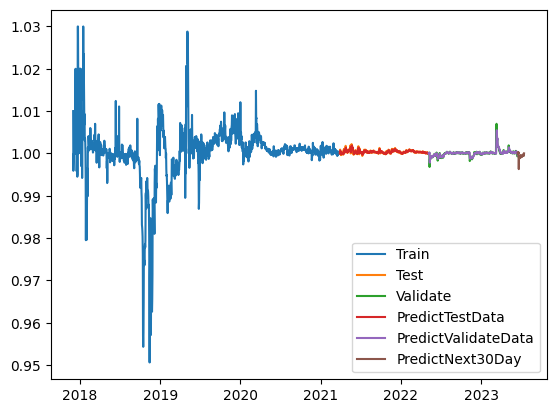

In [30]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])

plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(date_range, y_next_30_days)

plt.legend(['Train', 'Test', 'Validate','PredictTestData', 'PredictValidateData','PredictNext30Day'])
plt.show()